Pemrosesan Bahasa Alam (Natural Language Processing/NLP) adalah cabang ilmu yang menggabungkan komputer sains, kecerdasan buatan, dan linguistik untuk menciptakan model komputasional yang mampu memproses dan memahami bahasa manusia secara alami. Tujuan utamanya adalah mengajarkan komputer untuk memahami arti dan konteks di balik teks manusia, seperti pengelompokan semantik kata-kata, konversi teks menjadi ucapan, dan terjemahan bahasa. Dengan kemampuannya ini, NLP memiliki berbagai aplikasi, termasuk analisis sentimen, di mana tekniknya dapat digunakan untuk menginterpretasi dan mengklasifikasikan emosi (positif, negatif, atau netral) dalam data teks, memungkinkan organisasi untuk memahami pandangan masyarakat terhadap kata-kata atau topik tertentu.

Sentiment Analysis, di sisi lain, adalah salah satu aplikasi khusus dari NLP. Ini fokus pada interpretasi dan klasifikasi emosi (positif, negatif, atau netral) dalam data teks. Sentiment Analysis menggunakan konsep dan teknik NLP untuk menganalisis teks dan menentukan bagaimana perasaan atau sentimen yang terkandung dalam teks tersebut.


In [29]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.feature_extraction.text import TfidfVectorizer


Mengimpor kumpulan data

Dataset yang digunakan adalah dataset sentiment140. Ini berisi 1.600.000 tweet yang diekstraksi menggunakan Twitter API. Tweet telah diberi anotasi (0 = Negatif, 4 = Positif) dan dapat digunakan untuk mendeteksi sentimen.

[Data pelatihan tidak dikategorikan secara sempurna karena dibuat dengan menandai teks sesuai dengan emoji yang ada. Jadi, model apa pun yang dibuat menggunakan kumpulan data ini mungkin memiliki akurasi yang lebih rendah dari yang diharapkan, karena kumpulan data tersebut tidak dikategorikan secara sempurna.]

     sentimen: polaritas tweet (0 = negatif, 4 = positif)
     ids: Id tweet (2087)
     tanggal: tanggal tweet (Sab 16 Mei 23:58:44 UTC 2009)
     bendera: Kueri (lyx). Jika tidak ada query, maka nilainya adalah NO_QUERY.
     pengguna: pengguna yang menge-tweet (robotickilldozr)
     teks: teks tweet (Lyx keren)

hanya memerlukan sentimen dan kolom teks, jadi kolom lainnya tidak akan di pakai atau di buang.

Selain itu, akan diubahnya bidang sentimen sehingga memiliki nilai baru untuk mencerminkan sentimen. (0 = Negatif, 1 = Positif)


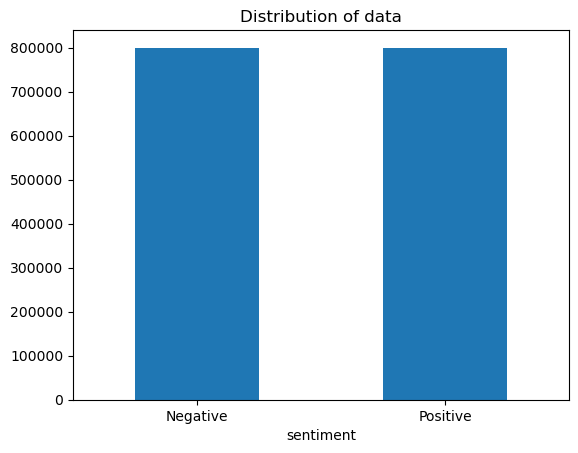

In [35]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('File_CSV/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

Teks Pre-Processing Data

Pemrosesan Awal Teks secara tradisional merupakan langkah penting untuk tugas Pemrosesan Bahasa Alami (NLP). Ini mengubah teks menjadi bentuk yang lebih mudah dicerna sehingga algoritme pembelajaran mesin dapat bekerja lebih baik.

Langkah-langkah Preprocessing yang dilakukan adalah:

     Huruf Kecil: Setiap teks diubah menjadi huruf kecil.
     Mengganti URL: Tautan yang dimulai dengan "http" atau "https" atau "www" diganti dengan "URL".
     Mengganti Emoji: Ganti emoji dengan menggunakan kamus yang telah ditentukan sebelumnya yang berisi emoji beserta artinya. (misal: ":)" menjadi "EMOJIsmile"
     Mengganti Nama Pengguna: Ganti @Usernames dengan kata "USER". (misalnya: "@Kaggle" ke "USER")
     Menghapus Non-Abjad: Mengganti karakter kecuali Digit dan Abjad dengan spasi.
     Menghapus Huruf Berurutan : 3 huruf atau lebih yang berurutan diganti dengan 2 huruf. (misal: "Heiyyy" menjadi "Hei")
     Menghapus Kata-Kata Pendek: Kata-kata yang panjangnya kurang dari 2 dihilangkan.
     Menghapus Stopwords: Stopwords adalah kata-kata bahasa Inggris yang tidak menambah banyak arti pada sebuah kalimat. Kata-kata tersebut dapat diabaikan dengan aman tanpa mengorbankan makna kalimatnya. (eg: "the", "he", "have")
     Lemmatisasi: Lemmatisasi adalah proses mengubah sebuah kata ke bentuk dasarnya. (e.g: “Great” to “Good”)

In [32]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [31]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [33]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 75 seconds


Menganalisis data

Sekarang akan menganalisis data yang telah diproses sebelumnya untuk memahaminya.Akan digunakannya Word Clouds untuk tweet Positif dan Negatif dari kumpulan data dan melihat kata mana yang paling sering muncul.

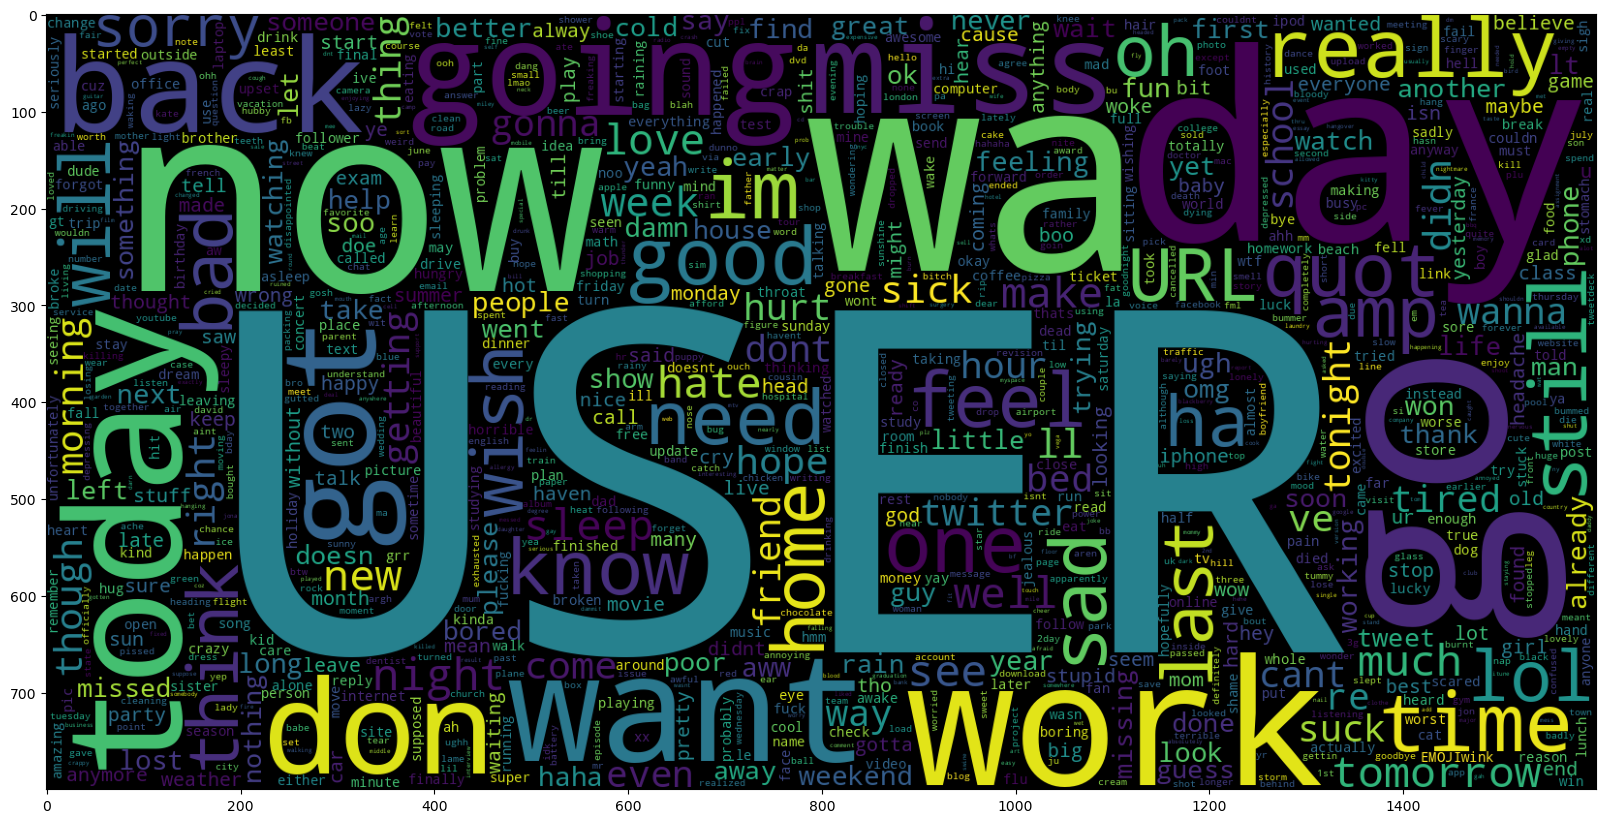

In [13]:
# Word-Cloud for Negative tweets.

data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

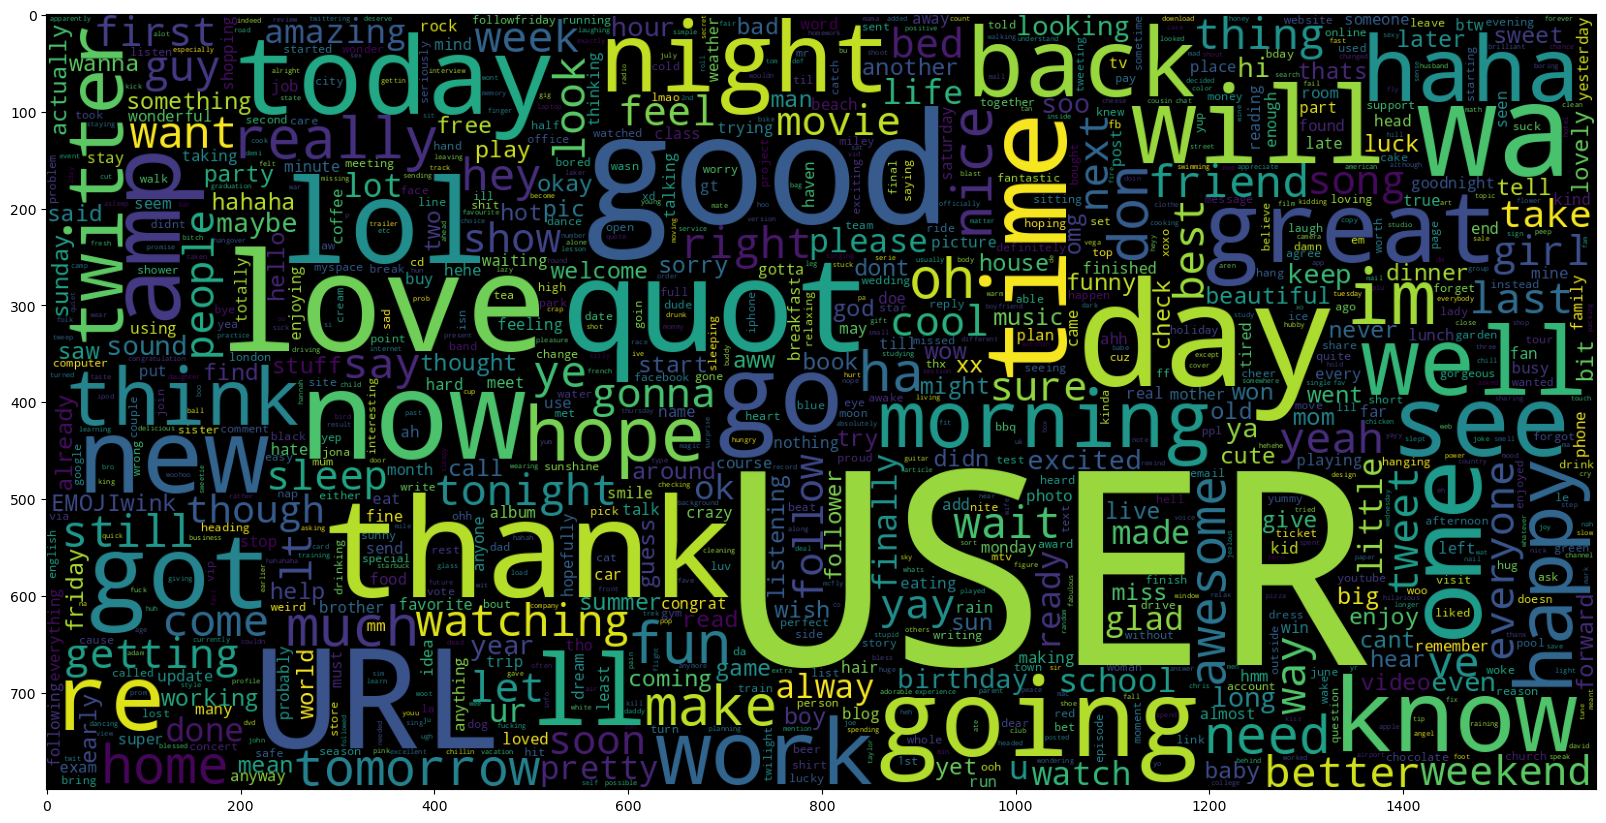

In [14]:
# Word-Cloud for Positive tweets.

data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

Memisahkan Data

Data yang telah diproses sebelumnya dibagi menjadi 2 set data:

     Data Pelatihan: Kumpulan data tempat model akan dilatih. Berisi 95% data.
     Data Uji: Kumpulan data yang menjadi dasar pengujian model. Berisi 5% data.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


Vektorisator TF-IDF

TF-IDF menunjukkan pentingnya kata tersebut untuk memahami dokumen atau kumpulan data. sebuah contoh. Misalkan, Dimilikinya kumpulan data tempat siswa menulis esai tentang topik Rumahku. Pada dataset ini, kata a muncul berkali-kali; itu adalah kata yang berfrekuensi tinggi dibandingkan dengan kata lain dalam kumpulan data. Kumpulan data tersebut berisi kata-kata lain seperti rumah, rumah, ruangan, dan sebagainya yang lebih jarang muncul, sehingga frekuensinya lebih rendah dan membawa lebih banyak informasi dibandingkan dengan kata tersebut. Inilah intuisi di balik TF-IDF.

TF-IDF Vectoriser mengonversi kumpulan dokumen mentah menjadi matriks fitur TF-IDF. Vectoriser biasanya dilatih hanya pada dataset X_train.

ngram_range adalah rentang jumlah kata secara berurutan. [misalnya "sangat mahal" adalah 2 gram yang dianggap sebagai fitur tambahan terpisah dari "sangat" dan "mahal" bila dimilikinya kisaran n-gram (1,2)]

max_features menentukan jumlah fitur yang perlu dipertimbangkan. [Diurutkan berdasarkan frekuensi fitur di seluruh korpus].

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming X_train is a list of text documents
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
X_train_tfidf = vectorizer.fit_transform(X_train)

print(f'Vectorizer fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))


Vectorizer fitted.
No. of feature_words:  500000


Mengubah kumpulan data

Mengubah dataset X_train dan X_test menjadi matriks Fitur TF-IDF dengan menggunakan TF-IDF Vectoriser. Kumpulan data ini akan digunakan untuk melatih model dan mengujinya.

In [19]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


Membuat dan Mengevaluasi Model

Membuat 3 jenis model berbeda untuk masalah analisis sentimen:

     Bernoulli Naif Bayes (BernoulliNB)
     Klasifikasi Vektor Dukungan Linier (LinearSVC)
     Regresi Logistik (LR)

In [20]:
# Evaluating the model.
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



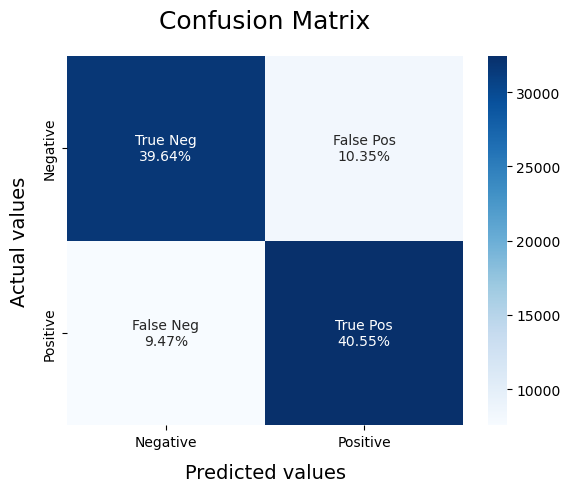

In [21]:
# BernoulliNB Model
# the BernoulliNB Model is the fastest to train and predict on. It also achieves 80% accuracy while calssifying.
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

/home/adeva/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



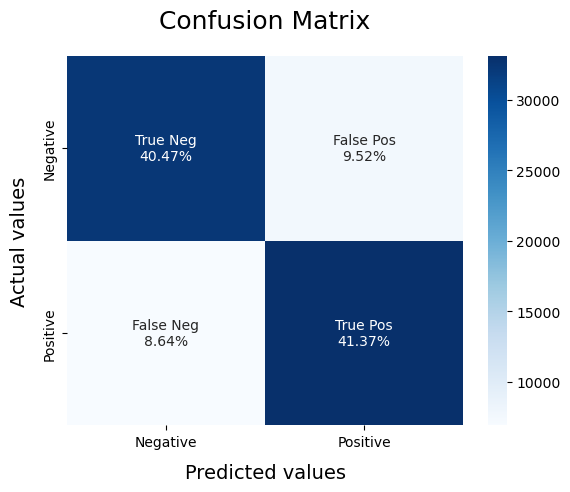

In [22]:
#LinearSVC Model

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



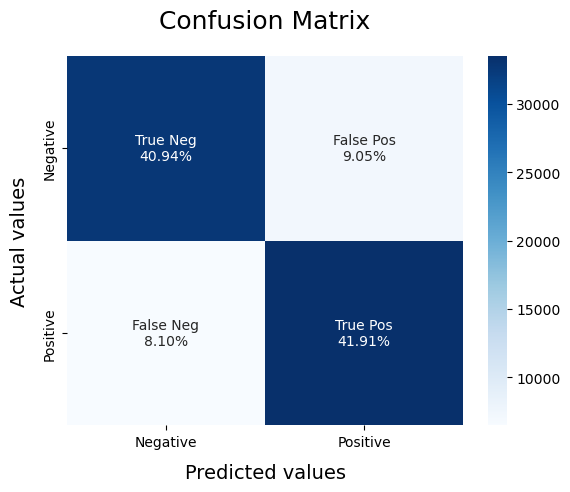

In [23]:
# Logistic Regression Model
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

Terlihat jelas bahwa Model Regresi Logistik memiliki kinerja terbaik dari semua model berbeda yang dicoba. Ini mencapai akurasi hampir 82% saat mengklasifikasikan sentimen tweet.
Meskipun perlu diperhatikan juga bahwa Model BernoulliNB adalah yang tercepat untuk dilatih dan diprediksi. Ini juga mencapai akurasi 80% saat melakukan kalsifikasi.

In [24]:
# Saving the Models
file = open('hasil_model/vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('hasil_model/Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('hasil_model/Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [28]:
def load_models():
    'hasil_model/vectoriser-ngram-(1,2).pickle'
    'hasil_model/Sentiment-BNB.pickle'
    'hasil_model/Sentiment-LR.pickle'
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good",
            "I'm sorry Dave, I'm afraid I can't do that.",
            "I'm Happy, that you're married with jason"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                                          text sentiment
0                               I hate twitter  Negative
1                   May the Force be with you.  Positive
2              Mr. Stark, I don't feel so good  Negative
3  I'm sorry Dave, I'm afraid I can't do that.  Negative
4    I'm Happy, that you're married with jason  Positive
